# Preprocess pictures for training

## Imports

In [1]:
import cv2 as cv
import os
import numpy as np
from tqdm.notebook import tqdm
import imutils
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import dlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
import utils_2d

## Starting point

After collecting pictures with the previous notebook, we have a few hundred pictures for each individual:

![](misc_pictures/Screenshot0.png)

While efforts were made in order to reduce undesired variation between classes, the pictures for one individual might still present different colors, backgrounds and lighting conditions than those of another individual.

Preliminary tests with models trained on these raw pictures resulted in very different predictions depending on the background, lighting conditions, colors and head tilting.

For this reason, the pictures were preprocessed in order to eliminate these types of variation as much as possible, through the following steps:

- transform the picture to grayscale
- use dlib's detector and predictor in order to align the head
- [equalize the picture's grayscale histogram](https://en.wikipedia.org/wiki/Histogram_equalization)
- apply a mask that hides most of the background

Additionally, a (cropped) picture displaying a face can be resized/shrinked before being aligned. This is useful for making aligning with dlib faster, and training with lower quality pictures may result in better predictions when trying to predict faces that are further away from the camera.

### Example

#### Load dlib detector and predictor

In [3]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=224)

#### Original picture

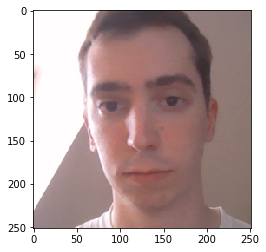

In [4]:
img = cv.imread("pictures_new/gian/gian_100.png")
plt.imshow(img[:,:,::-1])
plt.show()

#### Transform to grayscale

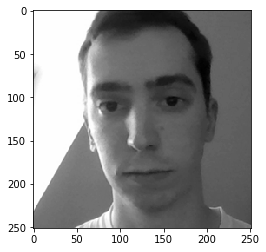

In [5]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")
plt.show()

#### Histogram equalization

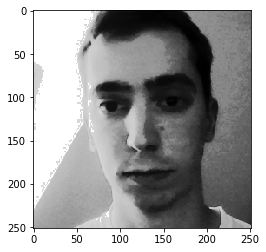

In [6]:
gray = cv.equalizeHist(gray)
plt.imshow(gray, cmap="gray")
plt.show()

#### Resize

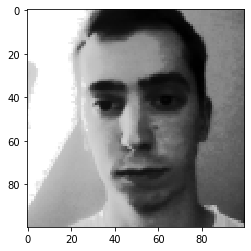

In [7]:
gray = imutils.resize(gray, width=100)
plt.imshow(gray, cmap="gray")
plt.show()

#### Use dlib and imutils to detect a face and align it

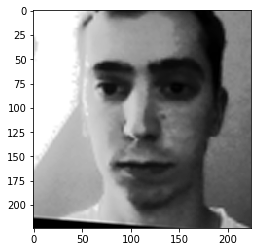

In [8]:
faces = detector(gray, 2)
gray = fa.align(gray, gray, faces[0])
plt.imshow(gray, cmap="gray")
plt.show()

#### Create mask that will hide the background

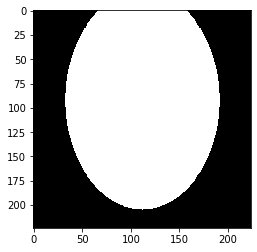

In [9]:
mask = utils_2d.create_mask()
plt.imshow(mask, cmap="gray")
plt.show()

#### Apply mask

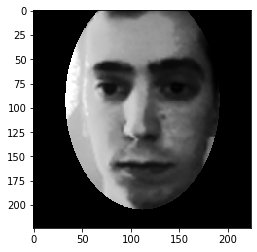

In [10]:
gray[~mask] = 0
plt.imshow(gray, cmap="gray")
plt.show()

All these steps can be performed with the function `preprocess_img` in `utils_2d.py`.

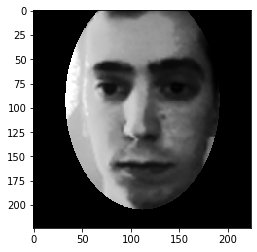

In [11]:
plt.imshow(utils_2d.preprocess_img(img, mask, 100, detector, fa), cmap="gray")
plt.show()

Other examples:

In [12]:
basedir = "pictures_new/"
our_pictures = [basedir+"gian/"+f for f in os.listdir(basedir+"gian")] +\
                [basedir+"khaled/"+f for f in os.listdir(basedir+"khaled")]

In [13]:
n = 20
cols = 10
n -= n % cols # only accept multiples of cols
some_pictures = np.random.choice(our_pictures, n, replace=False)

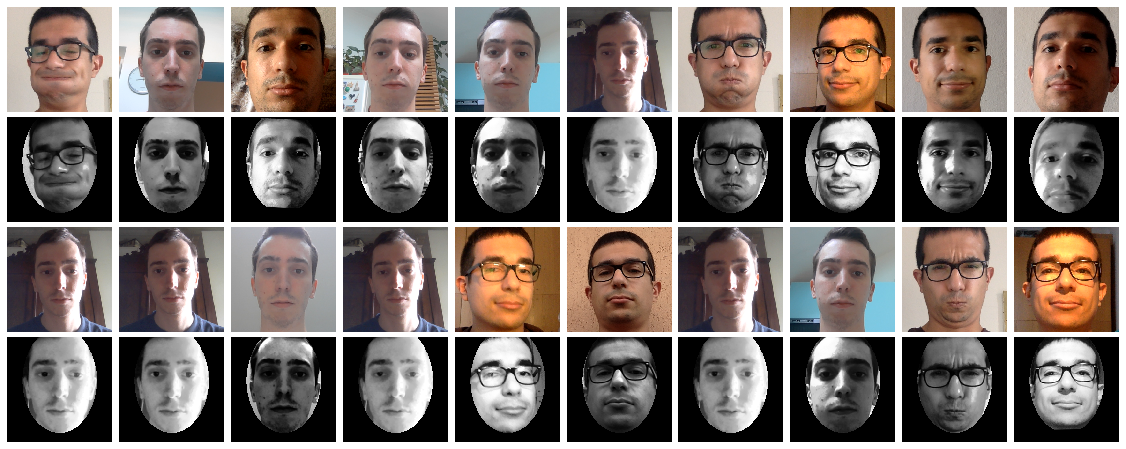

In [14]:
rows = n * 2 // cols
position = range(1, n*2 + 1)

fig = plt.figure(figsize=(cols*2,rows*2))
gs1 = gridspec.GridSpec(rows, cols)
gs1.update(wspace=0.025, hspace=0.05)
pi = 0
for i in range(n*2):
    if (i % cols) == (i % (cols*2)):
        path = some_pictures[pi]
        pi += 1
        img = cv.imread(path)
        processed_face = utils_2d.preprocess_img(img, mask, 200, detector, fa)
        
        ax1 = plt.subplot(gs1[i])
        ax1.axis('off')
        ax1.imshow(img[:,:,::-1])
        
        
        ax2 = plt.subplot(gs1[i+cols])
        ax2.axis('off')
        ax2.imshow(processed_face, cmap="gray")

## Apply preprocessing function to saved pictures

In [17]:
# might take a while depending on how much the picture is resized before being aligned with dlib
srcdir = "pictures_new/"
outdir = "pictures_masked_new_resized/"
new_width=50

for name in os.listdir(srcdir): # or choose the folders of interest

    indir = srcdir+name
    destdir = outdir+name
    
    print(f"Preprocessing pictures in {indir}\nSaving the preprocessed pictures to {destdir}")
    
    os.makedirs(destdir, exist_ok=True)
    
    for file in tqdm(os.listdir(indir)):

        img = cv.imread(indir+"/"+file)
        
        prep_img = utils_2d.preprocess_img(img, mask, new_width, detector, fa)
        
        cv.imwrite(destdir+"/"+file, prep_img)

Preprocessing pictures in pictures_new/khaled
Saving the preprocessed pictures to pictures_masked_new_resized/khaled



Preprocessing pictures in pictures_new/alinda
Saving the preprocessed pictures to pictures_masked_new_resized/alinda



Preprocessing pictures in pictures_new/gian
Saving the preprocessed pictures to pictures_masked_new_resized/gian



Preprocessing pictures in pictures_new/papi
Saving the preprocessed pictures to pictures_masked_new_resized/papi



Preprocessing pictures in pictures_new/mamma
Saving the preprocessed pictures to pictures_masked_new_resized/mamma



Preprocessing pictures in pictures_new/cami
Saving the preprocessed pictures to pictures_masked_new_resized/cami



Preprocessing pictures in pictures_new/alessandro
Saving the preprocessed pictures to pictures_masked_new_resized/alessandro



Preprocessing pictures in pictures_new/luca
Saving the preprocessed pictures to pictures_masked_new_resized/luca


# Move pictures to train/val/test folders

In [18]:
root_dir = 'pictures_masked_new_resized'
dest_dir = 'pictures_masked_new_resized_split' # or the same as root_dir

In [19]:
utils_2d.pictures_train_test_val_split(root_dir, dest_dir, verbose=True)

Current class: khaled
Total images: 459
Training: 321
Validation: 92
Testing: 46

Current class: alinda
Total images: 459
Training: 321
Validation: 92
Testing: 46

Current class: gian
Total images: 459
Training: 321
Validation: 92
Testing: 46

Current class: papi
Total images: 459
Training: 321
Validation: 92
Testing: 46

Current class: mamma
Total images: 459
Training: 321
Validation: 92
Testing: 46

Current class: cami
Total images: 459
Training: 321
Validation: 92
Testing: 46

Current class: alessandro
Total images: 459
Training: 321
Validation: 92
Testing: 46

Current class: luca
Total images: 459
Training: 321
Validation: 92
Testing: 46



# Eyes (tests for the future)

In [20]:
img = utils_2d.take_bgr_picture()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
faces = detector(gray, 1)

Might be interesting to see if we can obtain better results by adding a feature involving the eyes. The eyes' color might help the models.

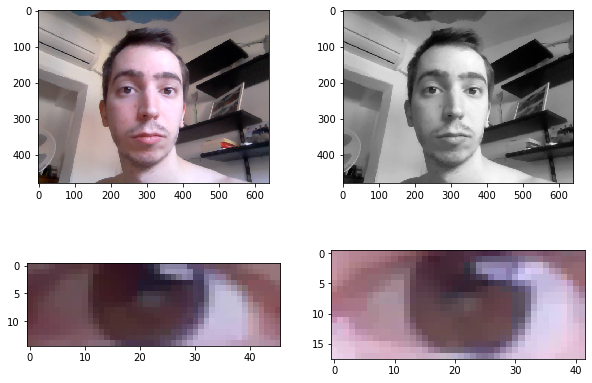

In [21]:
utils_2d.plot_eyes(img, faces, predictor, gray)